## 0.0 IMPORTS

In [70]:
import inflection
import math
import datetime

import pandas              as pd
import numpy               as np
import matplotlib          as mpl
import seaborn             as sns

from matplotlib            import pyplot as plt
from IPython.display       import Image
from matplotlib            import gridspec
from scipy                 import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

### 0.1 Helper Functions

In [59]:
sns.set(rc={'figure.figsize':(25,15)})

In [5]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

### 0.2 Loading data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on='Store')

## 1.0 DESCRICAO DOS DADOS

In [7]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old) )

#rename
df1.columns = cols_new

### 1.2 Data Dimensions

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


### 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0,inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',')else 0, axis=1)


### 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [18]:
#NOÇÃO DE NEGÓCIO E DETECTAR DISCREPANCIAS

#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max ) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

#concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/Users/fred/Documents/Repos/DS/sales_forecast_learn/salesforecast/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

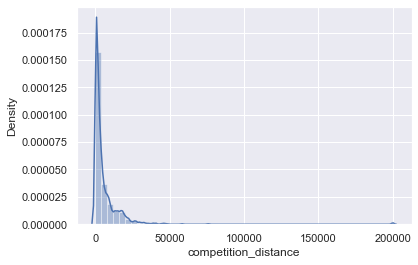

In [20]:
sns.set_style("darkgrid")
sns.distplot(df1['competition_distance'])

#### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

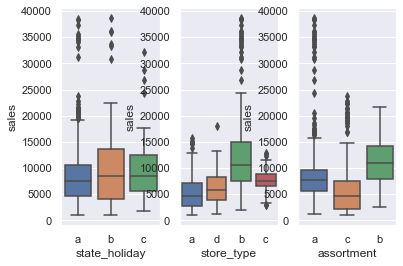

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

## 2.0 FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

### Mapa Mental

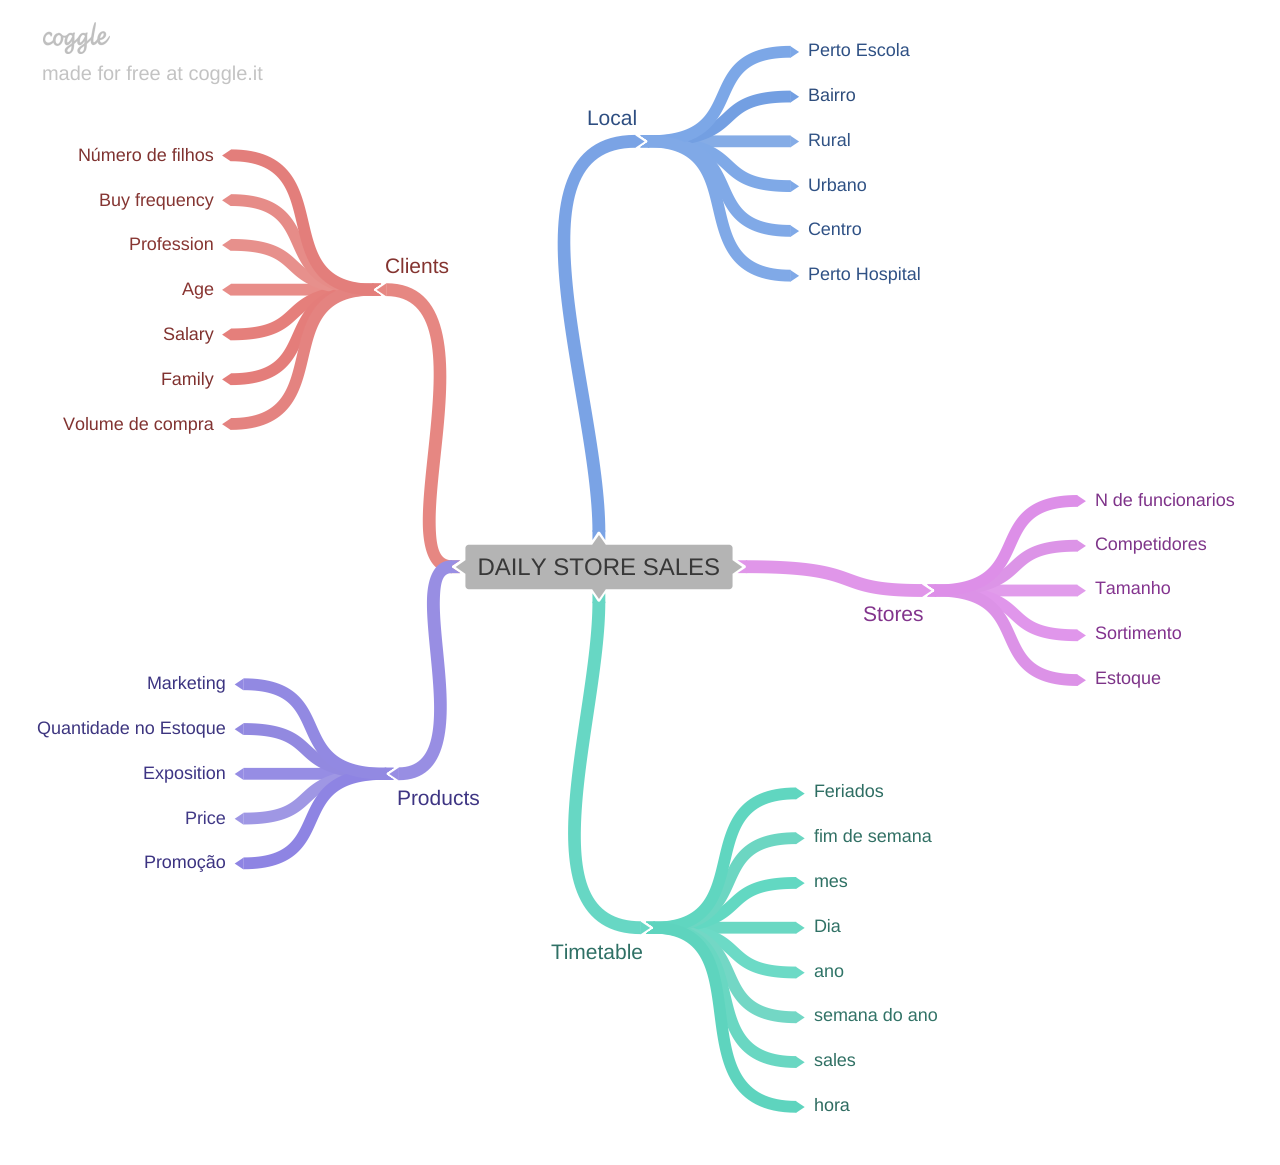

In [24]:
Image('img/mind_map_hypotesys.png')

### 2.1 Mind Map Hipotesys

#### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais


#### 2.1.2 Hipoteses do Produto

**1.** lojas que investem mais em marketing deveriam vender mais

**2.** lojas que expoem mais os produtos na vitrine, deveriam vender mais

**3.** lojas que tem preços menores, deveriam vender mais

**4.** lojas que tem preços menores por mais tempo deveriam vender mais

#### 2.1.3 Hipoteses do Tempo

**1.** Lojas que  tem mais feriados, deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses, deveriam vender mais

**3.** Lojas que abrem nos finais de semanaa deveriam vender mais 

### 2.2 Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# compatition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2["competition_time_month"] = ((df2 ['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holidays' if x == 'a' else 'easter_holidays' if x == 'b' else 'christmas' if x == 'c' else 'relugar_day')

In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,relugar_day,relugar_day,relugar_day,relugar_day,relugar_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,relugar_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,relugar_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,relugar_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,relugar_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,relugar_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1  Filtragem das Linhas

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Seleção das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis=1)

## 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

### DF Copy

In [30]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Response variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

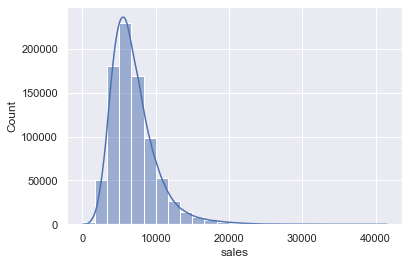

In [31]:
sns.histplot(df4['sales'], kde=True, bins=25)

#### 4.1.2 Numerical Variables

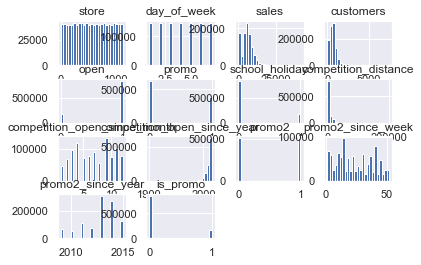

In [32]:
num_attributes.hist(bins=25);

#### 4.1.3 Categorical Variables

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/fred/Documents/Repos/DS/sales_forecast_learn/salesforecast/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fred/Documents/Repos/DS/sales_forecast_learn/salesforecast/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fred/Documents/Repos/DS/sales_forecast_learn/salesforecast/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `d

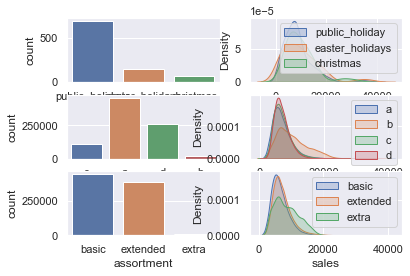

In [34]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'relugar_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holidays']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holidays']['sales'], label = 'easter_holidays', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)
plt.legend()

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)
plt.legend()


### 4.2 Análise Bivariada

#### H1 Lojas com maior sortimento deveriam vender mais = FALSO


<AxesSubplot:xlabel='year_week'>

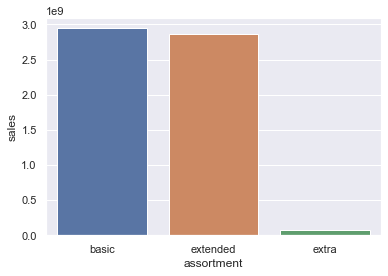

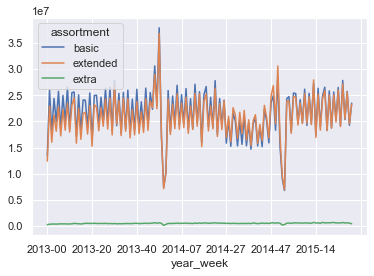

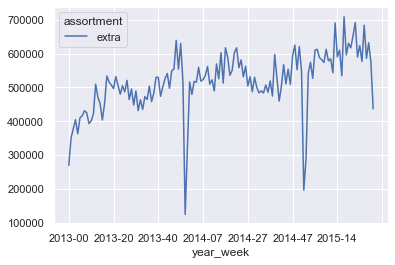

In [35]:
aux1 = df4[['assortment', 'sales']].groupby ('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y='sales',data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby (['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values= 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values= 'sales').plot()

#### H2 Lojas com competidores mais próximos deveriam vender menos = FALSO

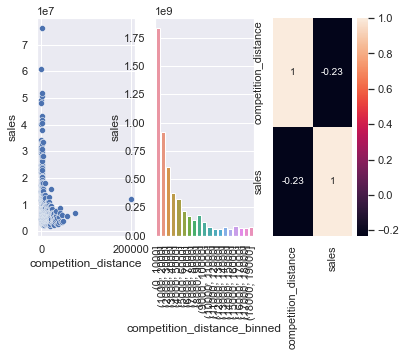

In [36]:
aux2_1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y= 'sales', data= aux2_1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux2_1['competition_distance_binned'] = pd.cut(aux2_1['competition_distance'], bins=bins)
aux2_2 = aux2_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2_2);
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux2_1.corr(method='pearson'), annot=True);

#### H3 Lojas com competidores a mais tempo deveriam vender mais = FALSO

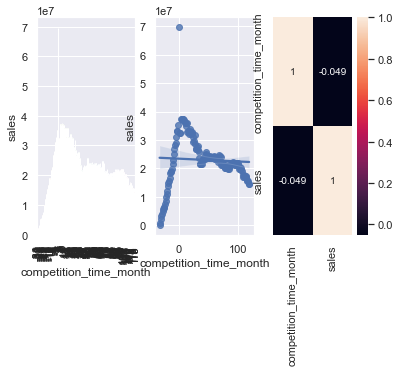

In [37]:
plt.subplot(1,3,1)
aux3_1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux3_2 = aux3_1[(aux3_1['competition_time_month'] < 120 ) & (aux3_1['competition_time_month'] != 0)]
sns.barplot(x= 'competition_time_month' ,y= 'sales' ,data= aux3_2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month' ,y= 'sales' ,data= aux3_2);

plt.subplot(1,3,3)
sns.heatmap(aux3_2.corr(method='pearson'), annot=True);

#### H4 Lojas com promoções ativas por mais tempo deveriam vender mais = FALSO

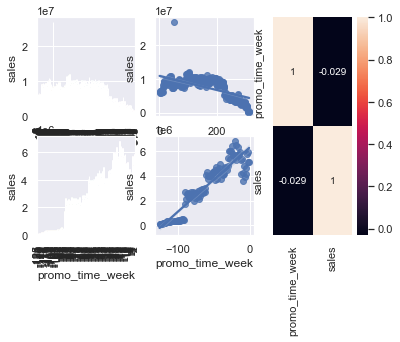

In [38]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendida
aux3 = aux1[aux1['promo_time_week'] < 0] #promo tradicional

grid = gridspec.GridSpec(2, 3)

plt.subplot (grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data= aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data= aux2)

plt.subplot (grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data= aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot = True);


#### H5 Lojas com mais dias de promoção deveria vender mais - HOLD      </s>

#### H6 Lojas com mais promoções consecutivas deveriam vender mais

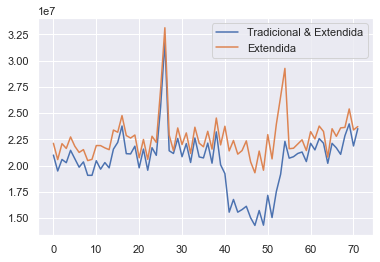

In [39]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

aux1 = df4[(df4['promo'] ==1 ) & (df4['promo2'] ==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] ==1 ) & (df4['promo2'] ==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);


#### H8 Lojas abertas durante o feriado de Natal, deveriam vender mais

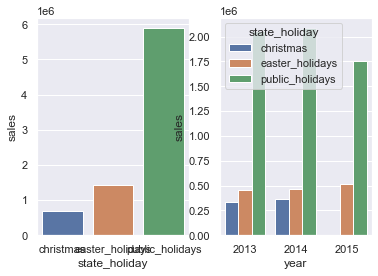

In [40]:
aux = df4[df4['state_holiday'] != 'relugar_day']

plt.subplot(1,2,1)
aux1=  aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1 );

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data = aux2 );


#### H9 Lojas deveriam vender mais ao longo dos anos = FALSO, tendência de queda

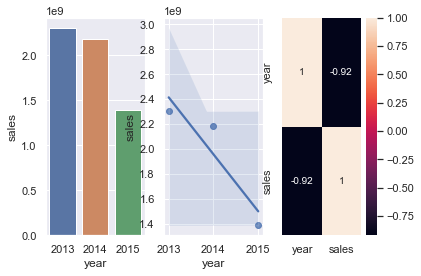

In [41]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### H10 Lojas deveriam vender mais no segundo semestre do ano = FALSO

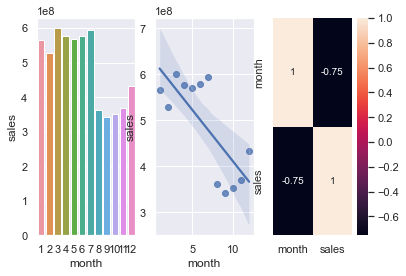

In [42]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H11 Lojas deveriam vender mais depois do dia 10 de cada mes = VERDADEIRO

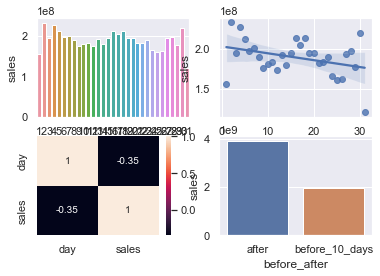

In [43]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if  x <=10
                                        else 'after')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

#### H12 Lojas deveriam vender menos aos finais de semana = VERDADEIRA

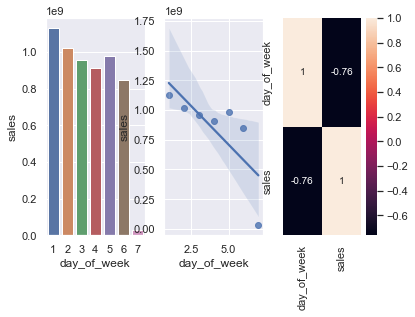

In [44]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H13 Lojas deveriam vender menos durante os feriados escolares

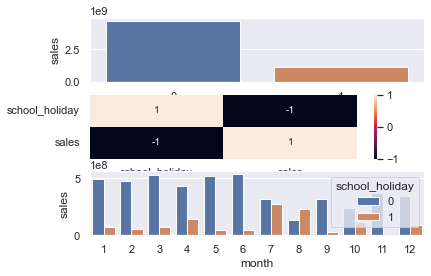

In [45]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(x='school_holiday',y='sales',data= aux1);

plt.subplot(3,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(3,1,3)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

### 4.3 Análise Multivariada

#### 4.3.1 Numerical Attributes

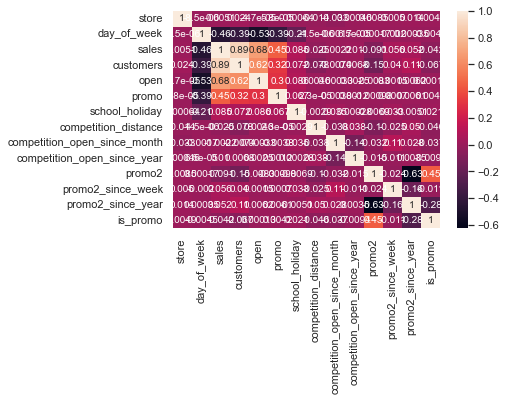

In [46]:
correlation = num_attributes.corr(method='pearson')

sns.heatmap (correlation,annot = True);

## 5.0 - Data Preparation

### 5.1 data_frame copy

In [47]:
df5 = df4.copy()

### 5.2 - Normalization (No data to be normalized)

### 5.3 Rescaling

#### Robust Scaler

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


### 5.4 Transform

In [ ]:
# day


# week_of_year


# day_of_week

#### 5.4.1 Encoding

In [50]:
# Encoding Types:
# - Label Encoding (No weight correlation)
# - One Hot Encoding 
# - Ordinal Encoding (weight correlation)
# - Target Encoding (Lots of categorical variables 100+ in general)
# - Frequency Encoding 
# - Embedding Encoding (NLP)


# state_holiday - One hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# month - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3,}
df5['assortment]'] = df5['assortment'].map(assortment_dict)